In [1]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import random

/home/xueheng/malith/.conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --------------------
# Set seeds for reproducibility
# --------------------
SEED = 512
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# --------------------
# Load and preprocess data
# --------------------
X = np.loadtxt('Estimated_H_NCALPHEE_1_sigma_0.75.csv', delimiter=',') 
x = X[:, :78]
y = X[:, 79]

# Scale features
x = StandardScaler().fit_transform(x)

# Shuffle data (keep features and labels aligned)
indices = np.arange(len(x))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Split into train+val (85%) and test (15%)
x_trainval, x_test, y_trainval, y_test = train_test_split(
    x, y, test_size=0.15, random_state=SEED
)

# Convert to PyTorch tensors
x_trainval = torch.FloatTensor(x_trainval)
y_trainval = torch.FloatTensor(y_trainval).view(-1, 1)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test).view(-1, 1)


In [4]:
# --------------------
# Set device (GPU or CPU)
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_trainval, y_trainval = x_trainval.to(device), y_trainval.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

# --------------------
# Define Tunable Feedforward Neural Network
# --------------------
class TunableFeedForwardNet(nn.Module):
    def __init__(self, input_dim, layer_sizes, activation):
        super().__init__()
        layers = []
        prev = input_dim
        for size in layer_sizes:
            layers.append(nn.Linear(prev, size))
            if activation == "relu":
                layers.append(nn.ReLU())
            elif activation == "leaky_relu":
                layers.append(nn.LeakyReLU())
            elif activation == "tanh":
                layers.append(nn.Tanh())
            prev = size
        layers.append(nn.Linear(prev, 1))  # Final layer
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# --------------------
# Optuna objective function with K-Fold CV + Early Stopping
# --------------------
def objective(trial):
    # Set per-trial random seed for reproducibility
    torch.manual_seed(SEED + trial.number)
    np.random.seed(SEED + trial.number)
    random.seed(SEED + trial.number)

    # Hyperparameter search space
    n_layers = trial.suggest_int("n_layers", 2, 5)
    layer_sizes = [trial.suggest_int(f"n_units_l{i}", 4, 512, step=32) for i in range(n_layers)]
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "tanh"])

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(x_trainval.cpu())):
        # Create train/val splits for this fold
        X_train_fold = torch.FloatTensor(x_trainval.cpu().numpy()[train_idx]).to(device)
        y_train_fold = torch.FloatTensor(y_trainval.cpu().numpy()[train_idx]).to(device)
        X_val_fold = torch.FloatTensor(x_trainval.cpu().numpy()[val_idx]).to(device)
        y_val_fold = torch.FloatTensor(y_trainval.cpu().numpy()[val_idx]).to(device)

        # DataLoader for mini-batches
        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Model, criterion, optimizer
        model = TunableFeedForwardNet(input_dim=x_trainval.shape[1],
                                      layer_sizes=layer_sizes,
                                      activation=activation).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Early stopping parameters
        best_val_loss = float('inf')
        patience = 5
        counter = 0

        for epoch in range(100):  # Max epochs
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

            # Validation loss
            model.eval()
            with torch.no_grad():
                val_output = model(X_val_fold)
                val_loss = criterion(val_output, y_val_fold)

            # Report for pruning
            trial.report(val_loss.item(), epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
            if not trial.should_prune():
                trial.report(val_loss.item(), epoch)
                
            # Early stopping check
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break  # Early stopping

        val_losses.append(best_val_loss)

    # Return average validation loss over all folds
    avg_val_loss = np.mean(val_losses)
    return avg_val_loss

# --------------------
# Run Optuna tuning
# --------------------
study = optuna.create_study(direction="minimize",sampler=optuna.samplers.TPESampler(seed=SEED),pruner=optuna.pruners.MedianPruner()) # Fix Optuna seed
study.optimize(objective, n_trials=20)

# --------------------
# Print best result
# --------------------
print("\nBest trial:")
print(f"  Average Validation MSE (5-Fold): {study.best_trial.value:.6f}")
print("  Parameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-09 16:44:39,487] A new study created in memory with name: no-name-ddb03d54-6754-4bd3-bef9-052531765434
/home/xueheng/malith/.local/lib/python3.9/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [4, 512] and step=32, but the range is not divisible by `step`. It will be replaced by [4, 484].
  warnings.warn(
/home/xueheng/malith/.local/lib/python3.9/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/xueheng/malith/.local/lib/python3.9/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/xueheng/malith/.local/lib/python3.9/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/xueheng/malith/.local/lib/python3.9/site-packages/optuna/trial/_trial.py:5


Best trial:
  Average Validation MSE (5-Fold): 0.000773
  Parameters:
    n_layers: 5
    n_units_l0: 388
    n_units_l1: 4
    n_units_l2: 324
    n_units_l3: 228
    n_units_l4: 484
    lr: 0.0004710936393425166
    batch_size: 16
    weight_decay: 2.2867083116593955e-06
    activation: leaky_relu


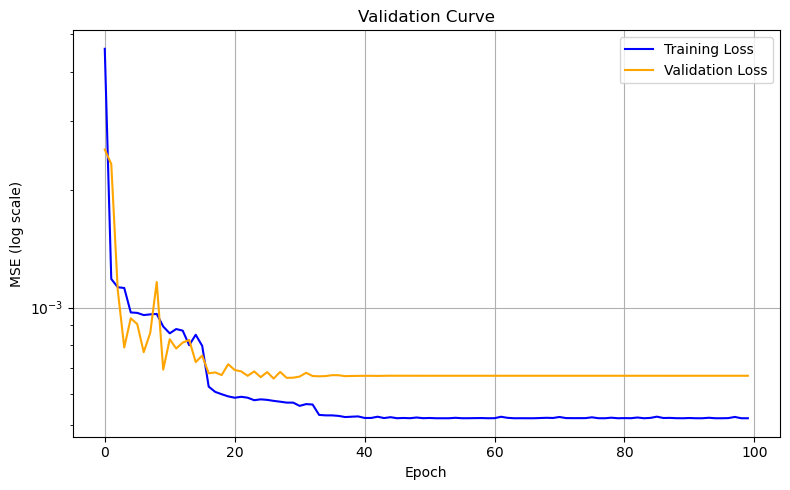

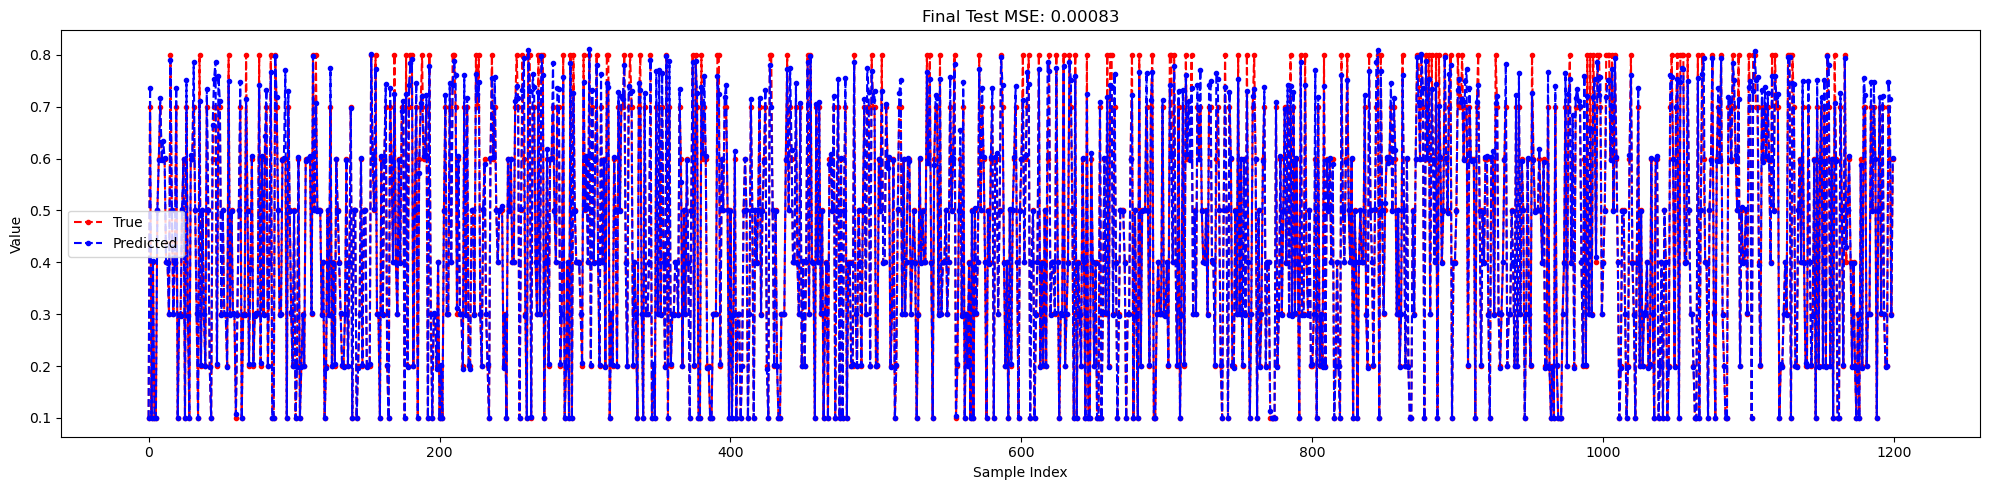

In [5]:
# Combine trainval for final model training
x_final_train = x_trainval
y_final_train = y_trainval

# Extract best hyperparameters
best_n_layers = study.best_trial.params["n_layers"]
best_layer_sizes = [study.best_trial.params[f"n_units_l{i}"] for i in range(best_n_layers)]
best_lr = study.best_trial.params["lr"]
best_batch_size = study.best_trial.params["batch_size"]
best_weight_decay = study.best_trial.params["weight_decay"]
best_activation = study.best_trial.params["activation"]

# Initialize best model
final_model = TunableFeedForwardNet(input_dim=x_final_train.shape[1], layer_sizes=best_layer_sizes, activation=best_activation).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Split final train into train/val for tracking loss
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_final_train.cpu(), y_final_train.cpu(), test_size=0.15, random_state=SEED
)
x_train_split = x_train_split.to(device)
y_train_split = y_train_split.to(device)
x_val_split = x_val_split.to(device)
y_val_split = y_val_split.to(device)

# DataLoader for mini-batches
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train_split, y_train_split)
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

# Re-train
epochs = 100
for epoch in range(epochs):
    final_model.train()
    batch_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = final_model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    epoch_loss = np.mean(batch_losses)
    train_losses.append(epoch_loss)

    final_model.eval()
    with torch.no_grad():
        val_output = final_model(x_val_split)
        val_loss = criterion(val_output, y_val_split)
        val_losses.append(val_loss.item())
        scheduler.step(val_loss)

# Evaluate on test set
final_model.eval()
with torch.no_grad():
    y_pred = final_model(x_test).cpu().numpy()  # Move to CPU before numpy
    mse_test = criterion(final_model(x_test), y_test).item()

# --- Plot 1: Validation Curve ---
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE (log scale)')
plt.title('Validation Curve')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.savefig("validation_curve_sigma_0.75.png", dpi=300)  # Save as high-res PNG
plt.show()

# --- Plot 2: Predictions vs. True ---
plt.figure(figsize=(20, 5))
plt.plot(y_test.cpu().numpy(), color='red', linestyle='--', marker='.', label='True')
plt.plot(y_pred, color='blue', linestyle='--', marker='.', label='Predicted')
plt.title(f'Final Test MSE: {mse_test:.5f}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

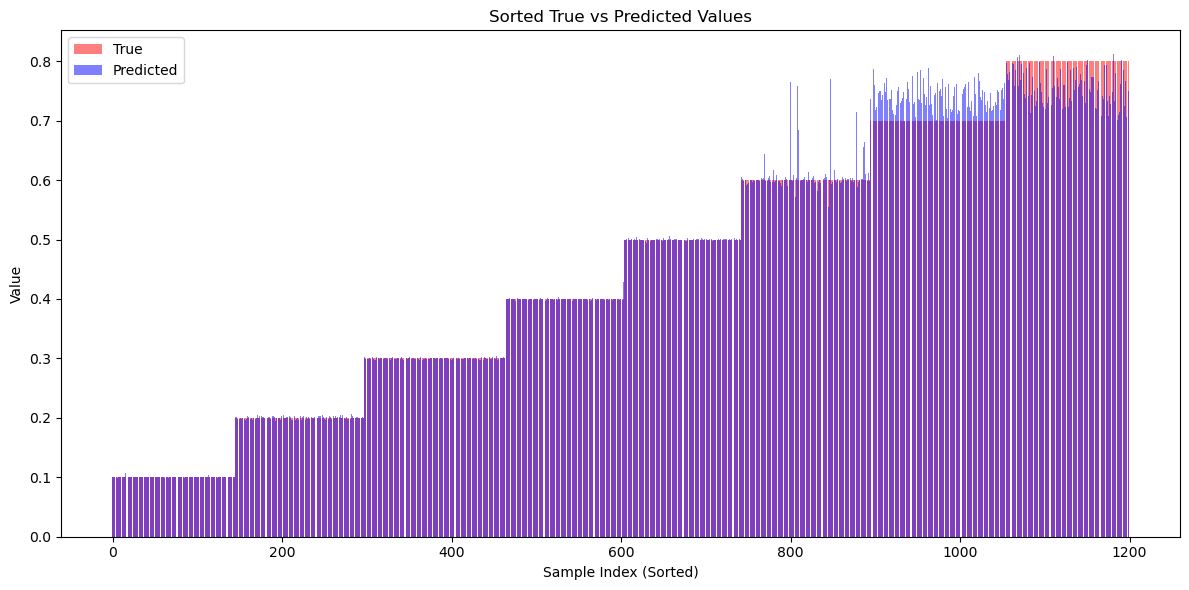

In [6]:
import numpy as np
import matplotlib.pyplot as plt

sorted_idx = np.argsort(y_test.cpu().numpy().flatten())
y_true_sorted = y_test.cpu().numpy().flatten()[sorted_idx]
y_pred_sorted = y_pred.flatten()[sorted_idx]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(y_true_sorted)), y_true_sorted, color="red", alpha=0.5, label="True")
plt.bar(np.arange(len(y_pred_sorted)), y_pred_sorted, color="blue", alpha=0.5, label="Predicted")
plt.xlabel("Sample Index (Sorted)")
plt.ylabel("Value")
plt.title("Sorted True vs Predicted Values")
plt.legend()
plt.tight_layout()
plt.show()

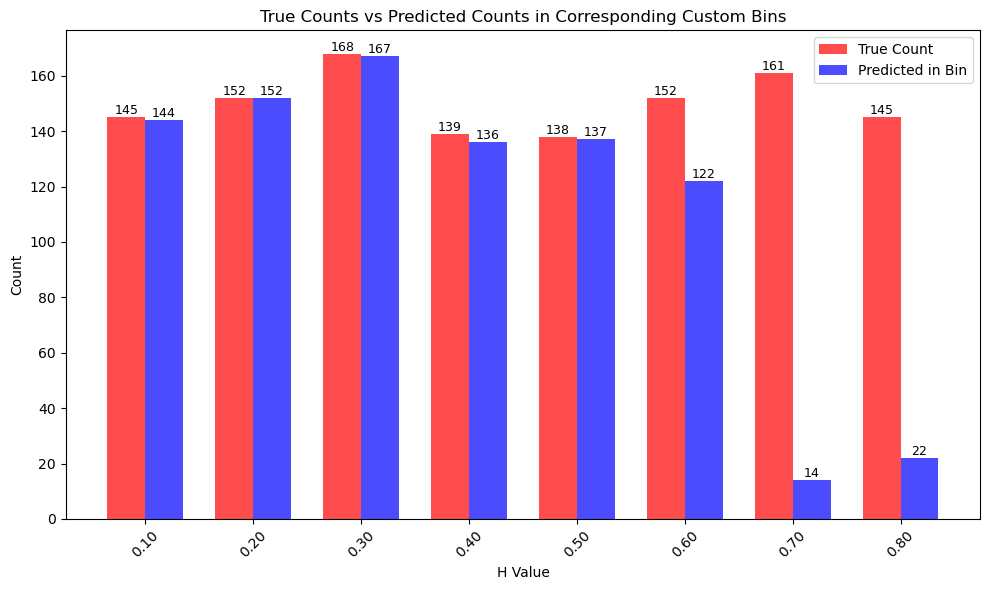

In [7]:
# Flatten arrays
y_true = y_test.cpu().numpy().flatten()
y_pred_flat = y_pred.flatten()

# Define true bins and custom predicted bins
true_bins = np.unique(y_true)  # Assuming discrete true values
pred_bins = [(0.09, 0.11), (0.19, 0.21), (0.29, 0.31),
             (0.39, 0.41), (0.49, 0.51), (0.59, 0.61),
             (0.69, 0.71), (0.79, 0.81)]

# Prepare counts
true_counts = []
pred_counts = []

for tb in true_bins:
    # Count how many samples have this true value
    mask = (y_true == tb)
    true_counts.append(np.sum(mask))

    # Find the corresponding predicted bin
    for pb_start, pb_end in pred_bins:
        if pb_start <= tb <= pb_end:
            pred_mask = (y_pred_flat[mask] >= pb_start) & (y_pred_flat[mask] <= pb_end)
            pred_counts.append(np.sum(pred_mask))
            break
    else:
        # If true value is outside predicted bin ranges
        pred_counts.append(0)

# Plot 2 bars per true value
x = np.arange(len(true_bins))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - bar_width/2, true_counts, width=bar_width, color="red", alpha=0.7, label="True Count")
bars2 = plt.bar(x + bar_width/2, pred_counts, width=bar_width, color="blue", alpha=0.7, label="Predicted in Bin")

# Annotate counts on bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Labels and formatting
plt.xticks(x, [f"{tb:.2f}" for tb in true_bins], rotation=45)
plt.xlabel("H Value")
plt.ylabel("Count")
plt.title("True Counts vs Predicted Counts in Corresponding Custom Bins")
plt.legend()
plt.savefig("prediction_comparison_sigma_0.75.png", dpi=300)  # Save as high-res PNG
plt.tight_layout()
plt.show()